In [1]:
import glob
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

def get_results_runs(ontology_name, reasoner, metrics_index):
    tasks = ["Membership", "Subsumption", "Link Prediction"]
    file_pattern = f"models/results/{reasoner}/{ontology_name}*.txt"  

    data = []

    for filepath in glob.glob(file_pattern, recursive=True):
        filename = filepath.split("\\")[-1] 
        parts = filename.replace(".txt", "").split("_")
        reasoner_name = f"{reasoner}"
        
        if len(parts) == 1:  # family.txt
            ontology = f"{ontology_name}"
            noise_type = "None"
            noise_level = 0
        elif len(parts) == 3: 
            ontology, noise_type, noise_level = parts
        else:
            print(f"⚠️ Skipping file (unexpected filename): {filename}")
            continue

        with open(filepath, "r", encoding="utf-8") as f:
            lines = f.readlines()

        current_task = None
        for line in lines:
            line = line.strip()
            if line.rstrip(":") in tasks:
                current_task = line.rstrip(":")
            elif line.startswith("Run") and current_task:
                run_values = [float(x.strip()) for x in re.split(r'&', line.split(":")[1]) if x.strip()]
                if len(run_values) > metrics_index:
                    metric_value = run_values[metrics_index]
                    data.append({
                        "Ontology": ontology,
                        "Reasoner": reasoner_name,
                        "NoiseType": noise_type,
                        "NoiseLevel": noise_level,
                        "Task": current_task,
                        "MRR": metric_value
                    })
    df = pd.DataFrame(data)
    return df

def plot_boxplot(df, task, noise_level, ax):    
    df_noise = df[(df['Task'] == task) & (df['NoiseLevel'] == noise_level)]
    df_no_noise = df[(df['Task'] == task) & (df['NoiseLevel'] == 0)]
    df_boxplot = pd.concat([df_noise, df_no_noise], ignore_index=True)

    sns.boxplot(
        x="NoiseType", 
        y="MRR", 
        hue="Reasoner",  
        data=df_boxplot,
        order=['None', 'random', 'gnn', 'logical'],
        ax=ax
    )

    new_labels = ["No Noise", "Random", "Statistical", "Logical"]
    ax.set_xticks(range(len(new_labels)))
    ax.set_xticklabels(new_labels)
    ax.set_title(f"Noise Level {noise_level}")
    ax.set_xlabel("Noise Type")
    ax.set_ylabel("MRR")

    # Remove individual legend
    ax.legend_.remove()

def main(ontology_name, task):

    df_box2el = get_results_runs(ontology_name, 'box2el', 0)
    df_owl2vec = get_results_runs(ontology_name, 'owl2vec', 0)
    df_gnn = get_results_runs(ontology_name, 'rgcn_reasoner', 0)
    df = pd.concat([df_box2el, df_owl2vec, df_gnn], ignore_index=True)

    noise_levels = ['0.25', '0.5', '0.75', '1']
    fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharey=True)
    axes = axes.flatten()

    for ax, nl in zip(axes, noise_levels):
        plot_boxplot(df, task=task, noise_level=nl, ax=ax)

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, title="Reasoner", loc='upper right', bbox_to_anchor=(1.05, 0.5))

    plt.suptitle(f"Boxplots by Noise Level for {task} Task - {ontology_name.capitalize()}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 0.9, 0.95])  
    plt.savefig(f"models/results/figures/{ontology_name}_boxplots_{task}.png", dpi=300, bbox_inches="tight")

⚠️ Skipping file (unexpected filename): family_test.txt
⚠️ Skipping file (unexpected filename): family_test.txt


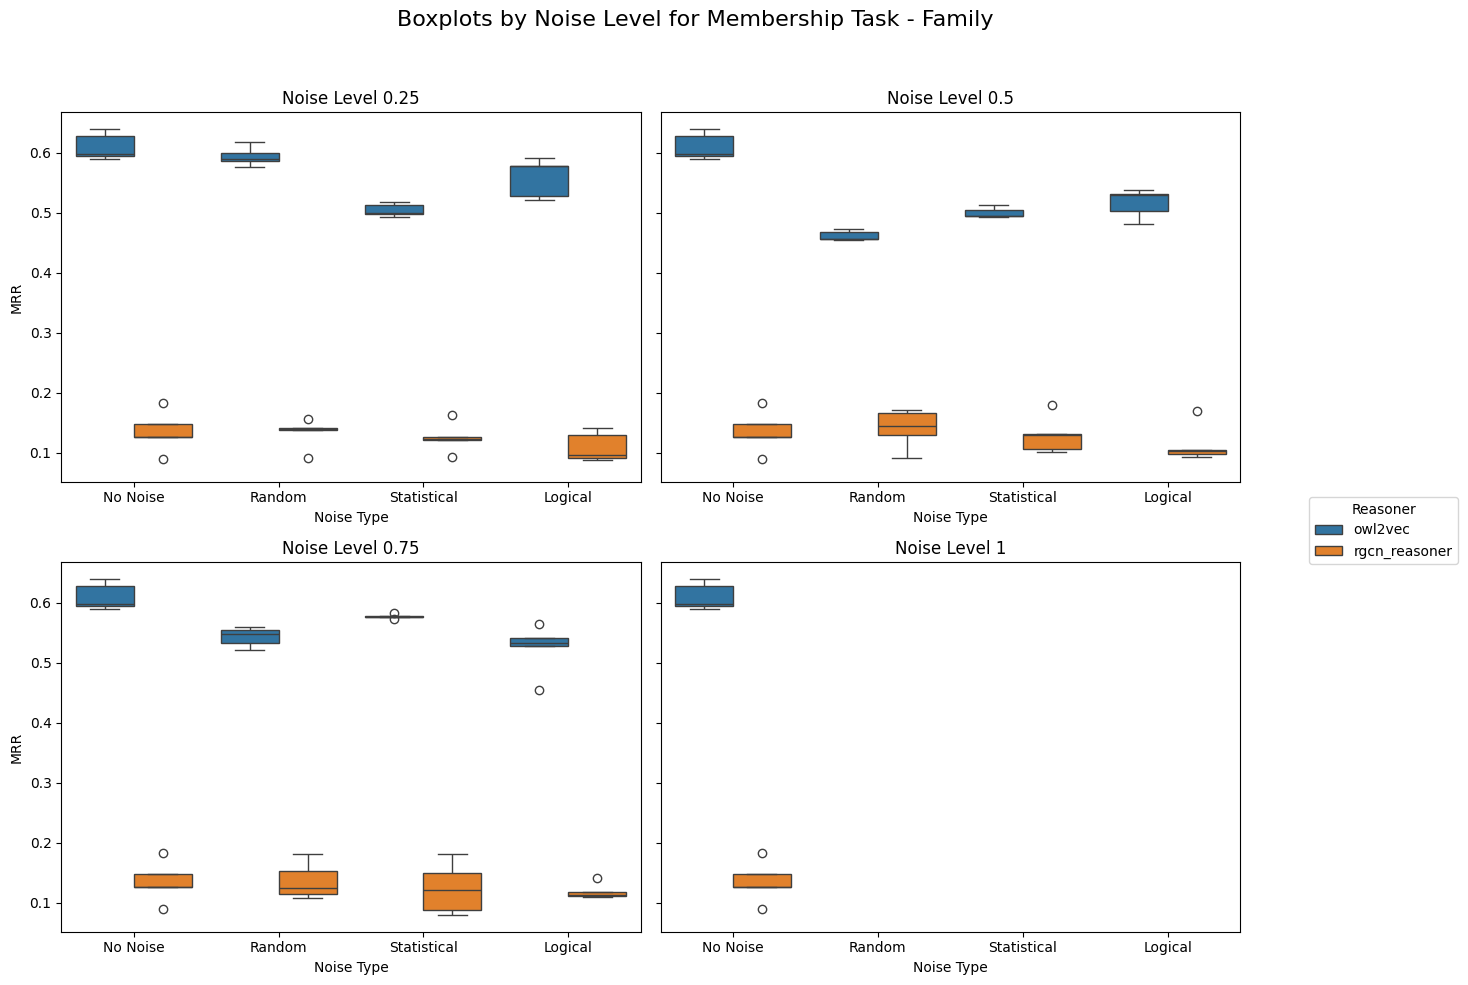

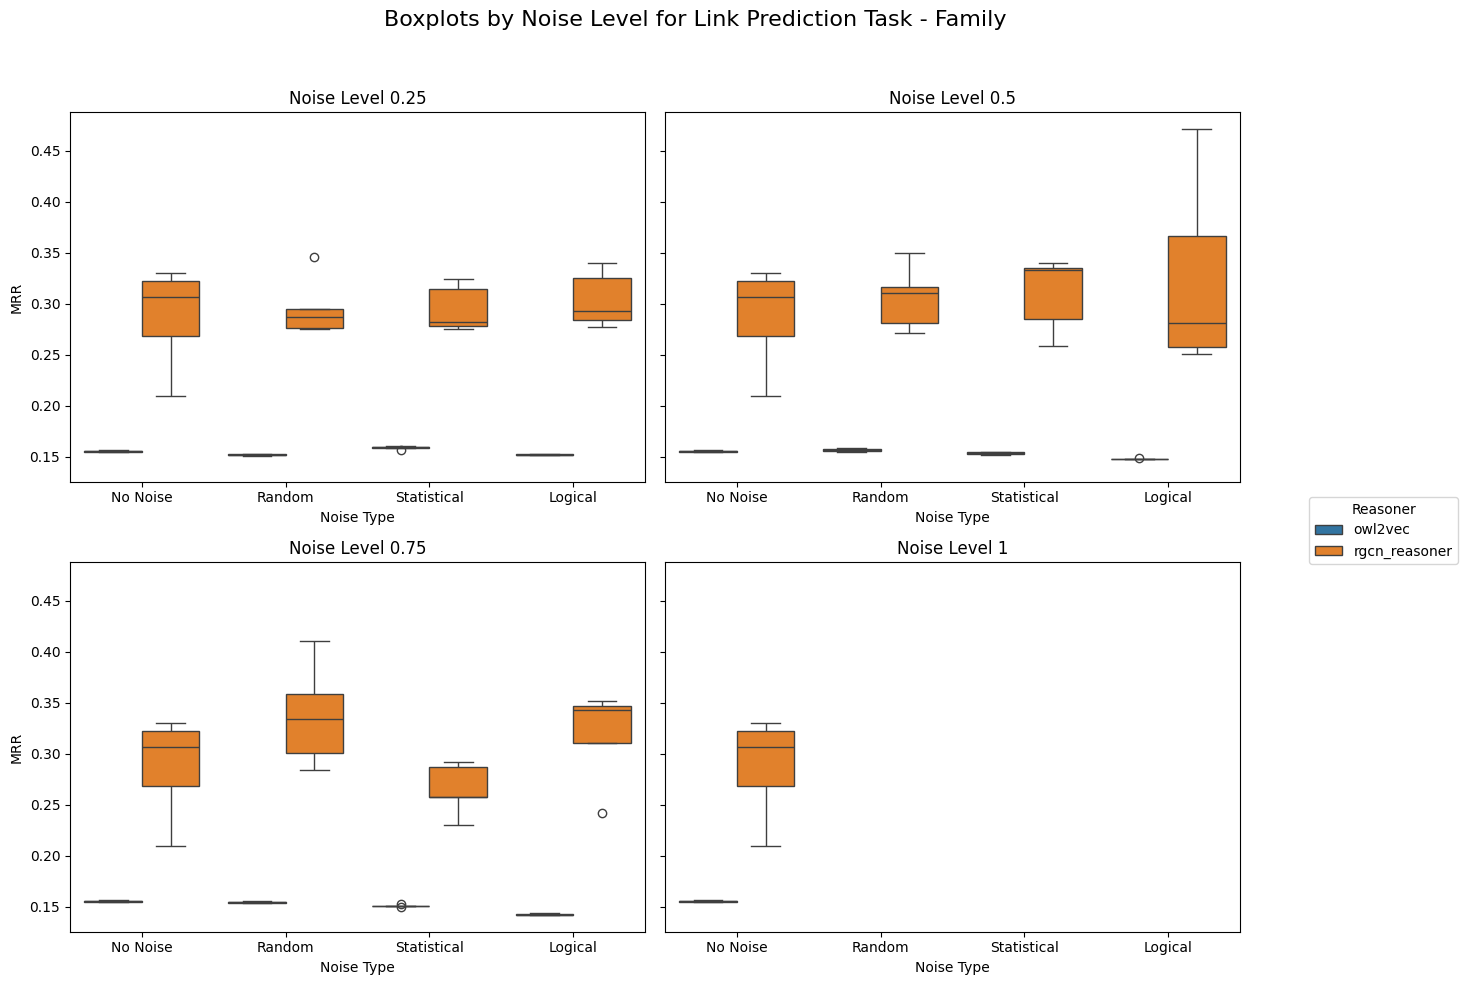

In [2]:
main("family", "Membership")  
main("family", "Link Prediction")  